In [6]:
import warnings
warnings.filterwarnings("ignore")
import os
import time
import torch # type: ignore
import random
import pathlib
import torchvision  # type: ignore
import numpy as np # type: ignore
import pandas as pd  # type: ignore
import torch.nn as nn # type: ignore
import splitfolders # type: ignore
import seaborn as sns # type: ignore
import torch.utils.data # type: ignore
from tabulate import tabulate # type: ignore
from datetime import datetime  
from termcolor import colored   # type: ignore
import matplotlib.pyplot as plt   # type: ignore
from IPython.display import display # type: ignore
import torchvision.transforms as transforms # type: ignore
from matplotlib.colors import LinearSegmentedColormap # type: ignore
from sklearn.metrics import confusion_matrix, classification_report # type: ignore
sns.set_style('whitegrid')

In [7]:
dir = 'Rice_Image_Dataset'

splitfolders.ratio(
    input = dir,
    output = 'imgs',
    seed = 42 , 
    ratio = (0.7,0.15,0.15)
)

Copying files: 75000 files [04:32, 274.82 files/s]


In [8]:
dir = 'imgs'
dir = pathlib.Path(dir)

In [9]:
transform = transforms.Compose(
    [
    transforms.Resize((250,250)),
    transforms.ToTensor(),
    transforms.Normalize((0),1)
    ]
)

In [44]:
BATCH_SIZE = 32

train_ds = torchvision.datasets.ImageFolder(
    os.path.join(dir,'train'),transform = transform
)
train_loader = torch.utils.data.DataLoader(
    train_ds,batch_size = BATCH_SIZE , shuffle = True,num_workers = 4,pin_memory = True
)
print(colored('Train Folder:','cyan'))
print(train_ds)

Train Folder:
Dataset ImageFolder
    Number of datapoints: 52500
    Root location: imgs\train
    StandardTransform
Transform: Compose(
               Resize(size=(250, 250), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=0, std=1)
           )


In [45]:
val_ds = torchvision.datasets.ImageFolder(
    os.path.join(dir,'val'),transform = transform
)
val_loader = torch.utils.data.DataLoader(
    val_ds , batch_size = BATCH_SIZE , shuffle = True,num_workers = 4
)
print(colored('Validation Folder:', 'cyan'))  
print(val_ds)

Validation Folder:
Dataset ImageFolder
    Number of datapoints: 11250
    Root location: imgs\val
    StandardTransform
Transform: Compose(
               Resize(size=(250, 250), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=0, std=1)
           )


In [46]:
test_ds = torchvision.datasets.ImageFolder(
    os.path.join(dir, 'test'), transform=transform 
)
test_loader = torch.utils.data.DataLoader(
    test_ds, batch_size=BATCH_SIZE, shuffle=True,num_workers=4
)

print(colored('Test Folder:', 'cyan'))  #
print(test_ds)

Test Folder:
Dataset ImageFolder
    Number of datapoints: 11250
    Root location: imgs\test
    StandardTransform
Transform: Compose(
               Resize(size=(250, 250), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=0, std=1)
           )


In [43]:
for dataset_name , data_loader in {'Train' : train_loader,'Validation':val_loader , 'Test':test_loader}.items():
    for images , labels in data_loader:
        print(colored(f'{dataset_name}:','cyan'))
        
        print (f'Images Shape [Batch_size , Channels , Height , Width]: {images.shape}')
        
        print(f'labels shape: {labels.shape}, Data type : {labels.dtype}\n')
        
        break

Train:
Images Shape [Batch_size , Channels , Height , Width]: torch.Size([32, 3, 250, 250])
labels shape: torch.Size([32]), Data type : torch.int64

Validation:
Images Shape [Batch_size , Channels , Height , Width]: torch.Size([32, 3, 250, 250])
labels shape: torch.Size([32]), Data type : torch.int64

Test:
Images Shape [Batch_size , Channels , Height , Width]: torch.Size([32, 3, 250, 250])
labels shape: torch.Size([32]), Data type : torch.int64



In [17]:
rice_variety_labels = {
    0: "Arborio",
    1: "Basmati",
    2: "Ipsala",
    3: "Jasmine",
    4: "Karacadag"}

In [20]:
for batch_images, labels in train_loader:
    break

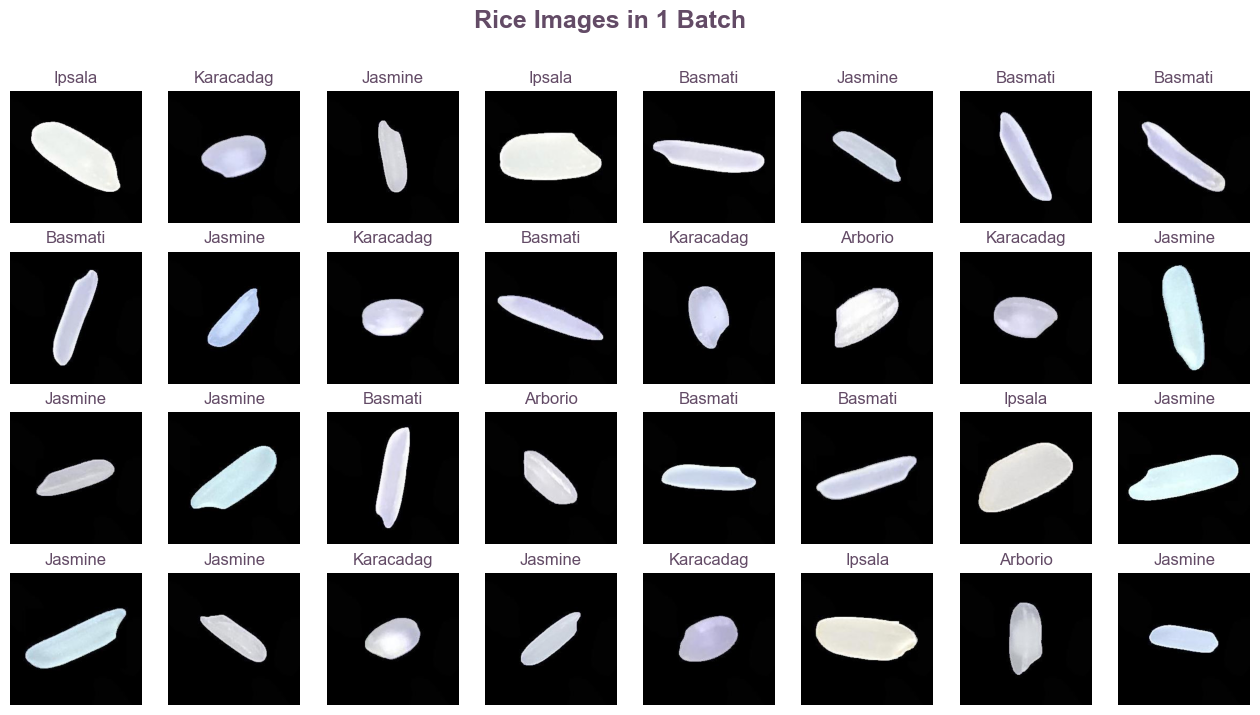

In [ ]:
plt.figure(figsize=(16, 8))
plt.suptitle('Rice Images in 1 Batch', fontsize=18, fontweight='bold', color='#634b66')

# Iterate through the first 32 images in the batch
for i in range(32):
    ax = plt.subplot(4, 8, i + 1)
    img = torch.permute(batch_images[i], (1, 2, 0))
    plt.imshow(img)
    
    label = rice_variety_labels[int(labels[i])]
    
    plt.title(label, color='#634b66')
    plt.axis('off')
plt.show()

In [25]:
image_data = []

for dataset_type in ['train','val','test']:
    dataset_dir = dir / dataset_type
    
    for class_name in os.listdir(dataset_dir):
        class_dir = dataset_dir / class_name
        image_files = os.listdir(class_dir)
        
        for image_file in image_files:
            image_path = class_dir / image_file
            image_data.append((str(image_path),class_name))


In [26]:
df = pd.DataFrame(image_data,columns=['path','label'])
df = df.sample(frac=1).reset_index(drop=True)

In [27]:
df

,path,label
0,imgs\train\Jasmine\Jasmine (12671).jpg,Jasmine
1,imgs\test\Basmati\basmati (14870).jpg,Basmati
2,imgs\train\Ipsala\Ipsala (8853).jpg,Ipsala
3,imgs\train\Ipsala\Ipsala (12884).jpg,Ipsala
4,imgs\train\Ipsala\Ipsala (2344).jpg,Ipsala
...,...,...
74995,imgs\train\Arborio\Arborio (13103).jpg,Arborio
74996,imgs\val\Basmati\basmati (10382).jpg,Basmati
74997,imgs\train\Karacadag\Karacadag (6694).jpg,Karacadag
74998,imgs\train\Ipsala\Ipsala (10685).jpg,Ipsala


In [47]:
class CNN(nn.Module):
    def __init__(self,unique_classes):
        super(CNN,self).__init__()
    
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2)),
            nn.BatchNorm2d(32),
            
            nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2)),
            nn.BatchNorm2d(64),
            
            nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2)),
            nn.BatchNorm2d(128),
    )
        self.dense_layers = nn.Sequential(
            nn.Linear(128*29*29,128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64,unique_classes)
    )
    
    def forward(self,x):
        out = self.conv_layers(x)
        out = out.view(out.size(0),-1)
        out = self.dense_layers(out)
        return out

In [48]:
model = CNN(unique_classes=5)
Device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(Device)

CNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (dense_layers): Sequential(
    (0): Linear(in_features=107648, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, ou

In [49]:
from torchsummary import summary
summary(model,(3,250,250))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 128, 29, 29]         --
|    └─Conv2d: 2-1                       [-1, 32, 248, 248]        896
|    └─ReLU: 2-2                         [-1, 32, 248, 248]        --
|    └─MaxPool2d: 2-3                    [-1, 32, 124, 124]        --
|    └─BatchNorm2d: 2-4                  [-1, 32, 124, 124]        64
|    └─Conv2d: 2-5                       [-1, 64, 122, 122]        18,496
|    └─ReLU: 2-6                         [-1, 64, 122, 122]        --
|    └─MaxPool2d: 2-7                    [-1, 64, 61, 61]          --
|    └─BatchNorm2d: 2-8                  [-1, 64, 61, 61]          128
|    └─Conv2d: 2-9                       [-1, 128, 59, 59]         73,856
|    └─ReLU: 2-10                        [-1, 128, 59, 59]         --
|    └─MaxPool2d: 2-11                   [-1, 128, 29, 29]         --
|    └─BatchNorm2d: 2-12                 [-1, 128, 29, 29]         256
├─Se

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 128, 29, 29]         --
|    └─Conv2d: 2-1                       [-1, 32, 248, 248]        896
|    └─ReLU: 2-2                         [-1, 32, 248, 248]        --
|    └─MaxPool2d: 2-3                    [-1, 32, 124, 124]        --
|    └─BatchNorm2d: 2-4                  [-1, 32, 124, 124]        64
|    └─Conv2d: 2-5                       [-1, 64, 122, 122]        18,496
|    └─ReLU: 2-6                         [-1, 64, 122, 122]        --
|    └─MaxPool2d: 2-7                    [-1, 64, 61, 61]          --
|    └─BatchNorm2d: 2-8                  [-1, 64, 61, 61]          128
|    └─Conv2d: 2-9                       [-1, 128, 59, 59]         73,856
|    └─ReLU: 2-10                        [-1, 128, 59, 59]         --
|    └─MaxPool2d: 2-11                   [-1, 128, 29, 29]         --
|    └─BatchNorm2d: 2-12                 [-1, 128, 29, 29]         256
├─Se

In [50]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
num_epochs = 5

train_losses = np.zeros(num_epochs)
val_losses = np.zeros(num_epochs)
train_acc = np.zeros(num_epochs)
val_acc = np.zeros(num_epochs)

In [51]:
for epoch in range(num_epochs):
    model.train()
    train_loss = []
    val_loss = []
    n_correct_train = 0
    n_total_train = 0
    
    for images, labels in train_loader:
        images, labels = images.to(Device), labels.to(Device)  # Move data to the GPU
        
        optimizer.zero_grad()
        
        y_pred = model(images)
        loss = criterion(y_pred, labels)
        
        loss.backward()
        optimizer.step()
        
        train_loss.append(loss.item())
        
        _, predicted_labels = torch.max(y_pred, 1)
        n_correct_train += (predicted_labels == labels).sum().item()
        n_total_train += labels.shape[0]
    
    train_loss = np.mean(train_loss)
    train_losses[epoch] = train_loss
    train_acc[epoch] = n_correct_train / n_total_train
    
    model.eval()
    n_correct_val = 0
    n_total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(Device), labels.to(Device)  # Move data to the GPU
            
            y_pred = model(images)
            loss = criterion(y_pred, labels)
            val_loss.append(loss.item())
            
            _, predicted_labels = torch.max(y_pred, 1)
            n_correct_val += (predicted_labels == labels).sum().item()
            n_total_val += labels.shape[0]
    
    val_loss = np.mean(val_loss)
    val_losses[epoch] = val_loss
    val_acc[epoch] = n_correct_val / n_total_val
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc[epoch]:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc[epoch]:.4f}')

Epoch 1/5, Train Loss: 0.2811, Train Acc: 0.9045, Val Loss: 0.1149, Val Acc: 0.9549
Epoch 2/5, Train Loss: 0.1041, Train Acc: 0.9669, Val Loss: 0.1204, Val Acc: 0.9559
Epoch 3/5, Train Loss: 0.0581, Train Acc: 0.9816, Val Loss: 0.0346, Val Acc: 0.9908
Epoch 4/5, Train Loss: 0.0525, Train Acc: 0.9842, Val Loss: 0.0390, Val Acc: 0.9876
Epoch 5/5, Train Loss: 0.0462, Train Acc: 0.9871, Val Loss: 0.0374, Val Acc: 0.9892


In [52]:
torch.save(model.state_dict(), 'rice_classification.pth')

In [53]:
history = {
    'Train_Loss': train_losses,
    'Validation_Loss': val_losses,
    'Train_Accuracy': train_acc,
    'Validation_Accuracy': val_acc
}

result_df = pd.DataFrame(history)

print(tabulate(result_df, headers='keys', tablefmt='psql'))

+----+--------------+-------------------+------------------+-----------------------+
|    |   Train_Loss |   Validation_Loss |   Train_Accuracy |   Validation_Accuracy |
|----+--------------+-------------------+------------------+-----------------------|
|  0 |    0.281096  |         0.114944  |         0.904533 |              0.954933 |
|  1 |    0.104147  |         0.120365  |         0.966933 |              0.955911 |
|  2 |    0.0581274 |         0.0346485 |         0.981581 |              0.990844 |
|  3 |    0.0525441 |         0.0389642 |         0.984171 |              0.987644 |
|  4 |    0.0462116 |         0.0374041 |         0.987086 |              0.989156 |
+----+--------------+-------------------+------------------+-----------------------+


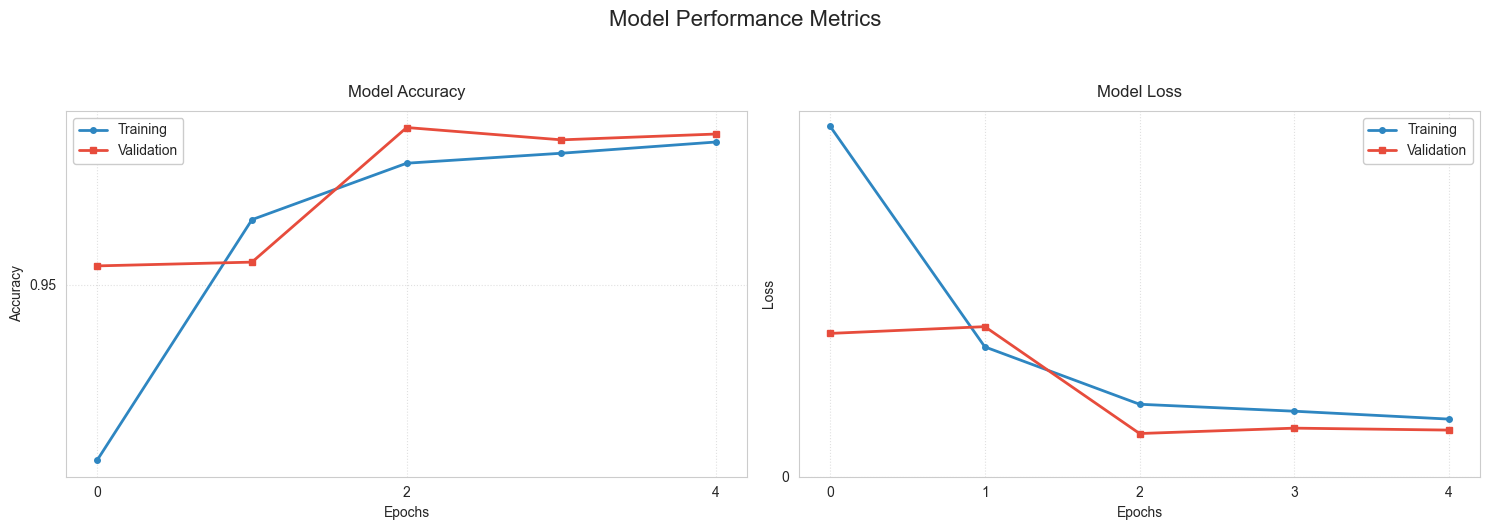

In [61]:
x = np.arange(len(result_df))

# Set style

colors = {'train': '#2E86C1', 'val': '#E74C3C'}

# Create figure and subplots
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Model Performance Metrics', fontsize=16, y=1.05)

# Plot Accuracy
ax[0].plot(x, result_df.Train_Accuracy, label='Training', 
           color=colors['train'], linewidth=2, marker='o', markersize=4)
ax[0].plot(x, result_df.Validation_Accuracy, label='Validation',
           color=colors['val'], linewidth=2, marker='s', markersize=4)
ax[0].set_title('Model Accuracy', pad=10)
ax[0].set_yticks(np.arange(0.95, 1.01))
ax[0].set_xticks(np.arange(0, len(result_df), 2))
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].grid(True, linestyle=':', alpha=0.6)
ax[0].grid(True, which='minor', linestyle=':', alpha=0.3)
ax[0].legend(frameon=True, facecolor='white', framealpha=1)

# Plot Loss
ax[1].plot(x, result_df.Train_Loss, label='Training',
           color=colors['train'], linewidth=2, marker='o', markersize=4)
ax[1].plot(x, result_df.Validation_Loss, label='Validation',
           color=colors['val'], linewidth=2, marker='s', markersize=4)
ax[1].set_title('Model Loss', pad=10)
ax[1].set_xticks(np.arange(0, len(result_df)))
ax[1].set_yticks(np.arange(0, 0.085))
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].grid(True, linestyle=':', alpha=0.6)
ax[1].grid(True, which='minor', linestyle=':', alpha=0.3)
ax[1].legend(frameon=True, facecolor='white', framealpha=1)

# Adjust layout
plt.tight_layout()
plt.show()

In [63]:
with torch.no_grad():
    model.eval()
    start_time = datetime.now()
    test_loss = []
    total_correct = 0
    total_samples = 0

    for images, labels in test_loader:
        images = images.to(Device)
        labels = labels.to(Device)

        predictions = model(images)
        loss = criterion(predictions, labels)

        test_loss.append(loss.item())

        _, predicted_classes = torch.max(predictions, 1)
        total_correct += (predicted_classes == labels).sum().item()
        total_samples += labels.size(0)

    avg_test_loss = np.mean(test_loss)
    test_accuracy = total_correct / total_samples
    elapsed_time = datetime.now() - start_time

    print(colored(f'Loss: {avg_test_loss:.4f}\nAccuracy: {test_accuracy:.4f}\nDuration: {elapsed_time}', 'cyan'))

Loss: 0.0345
Accuracy: 0.9883
Duration: 0:00:51.681621


In [64]:
model_on_device = model.to(Device)

true_labels_list = []
predicted_labels_list = []

for batch_images, batch_labels in test_loader:
    batch_images = batch_images.to(Device)
    batch_labels = batch_labels.numpy()
    output_predictions = model_on_device(batch_images)
    _, predicted_batch_labels = torch.max(output_predictions.data, 1)
    predicted_batch_labels = predicted_batch_labels.detach().cpu().numpy()
    true_labels_list = np.append(true_labels_list, batch_labels)
    predicted_labels_list = np.append(predicted_labels_list, predicted_batch_labels)

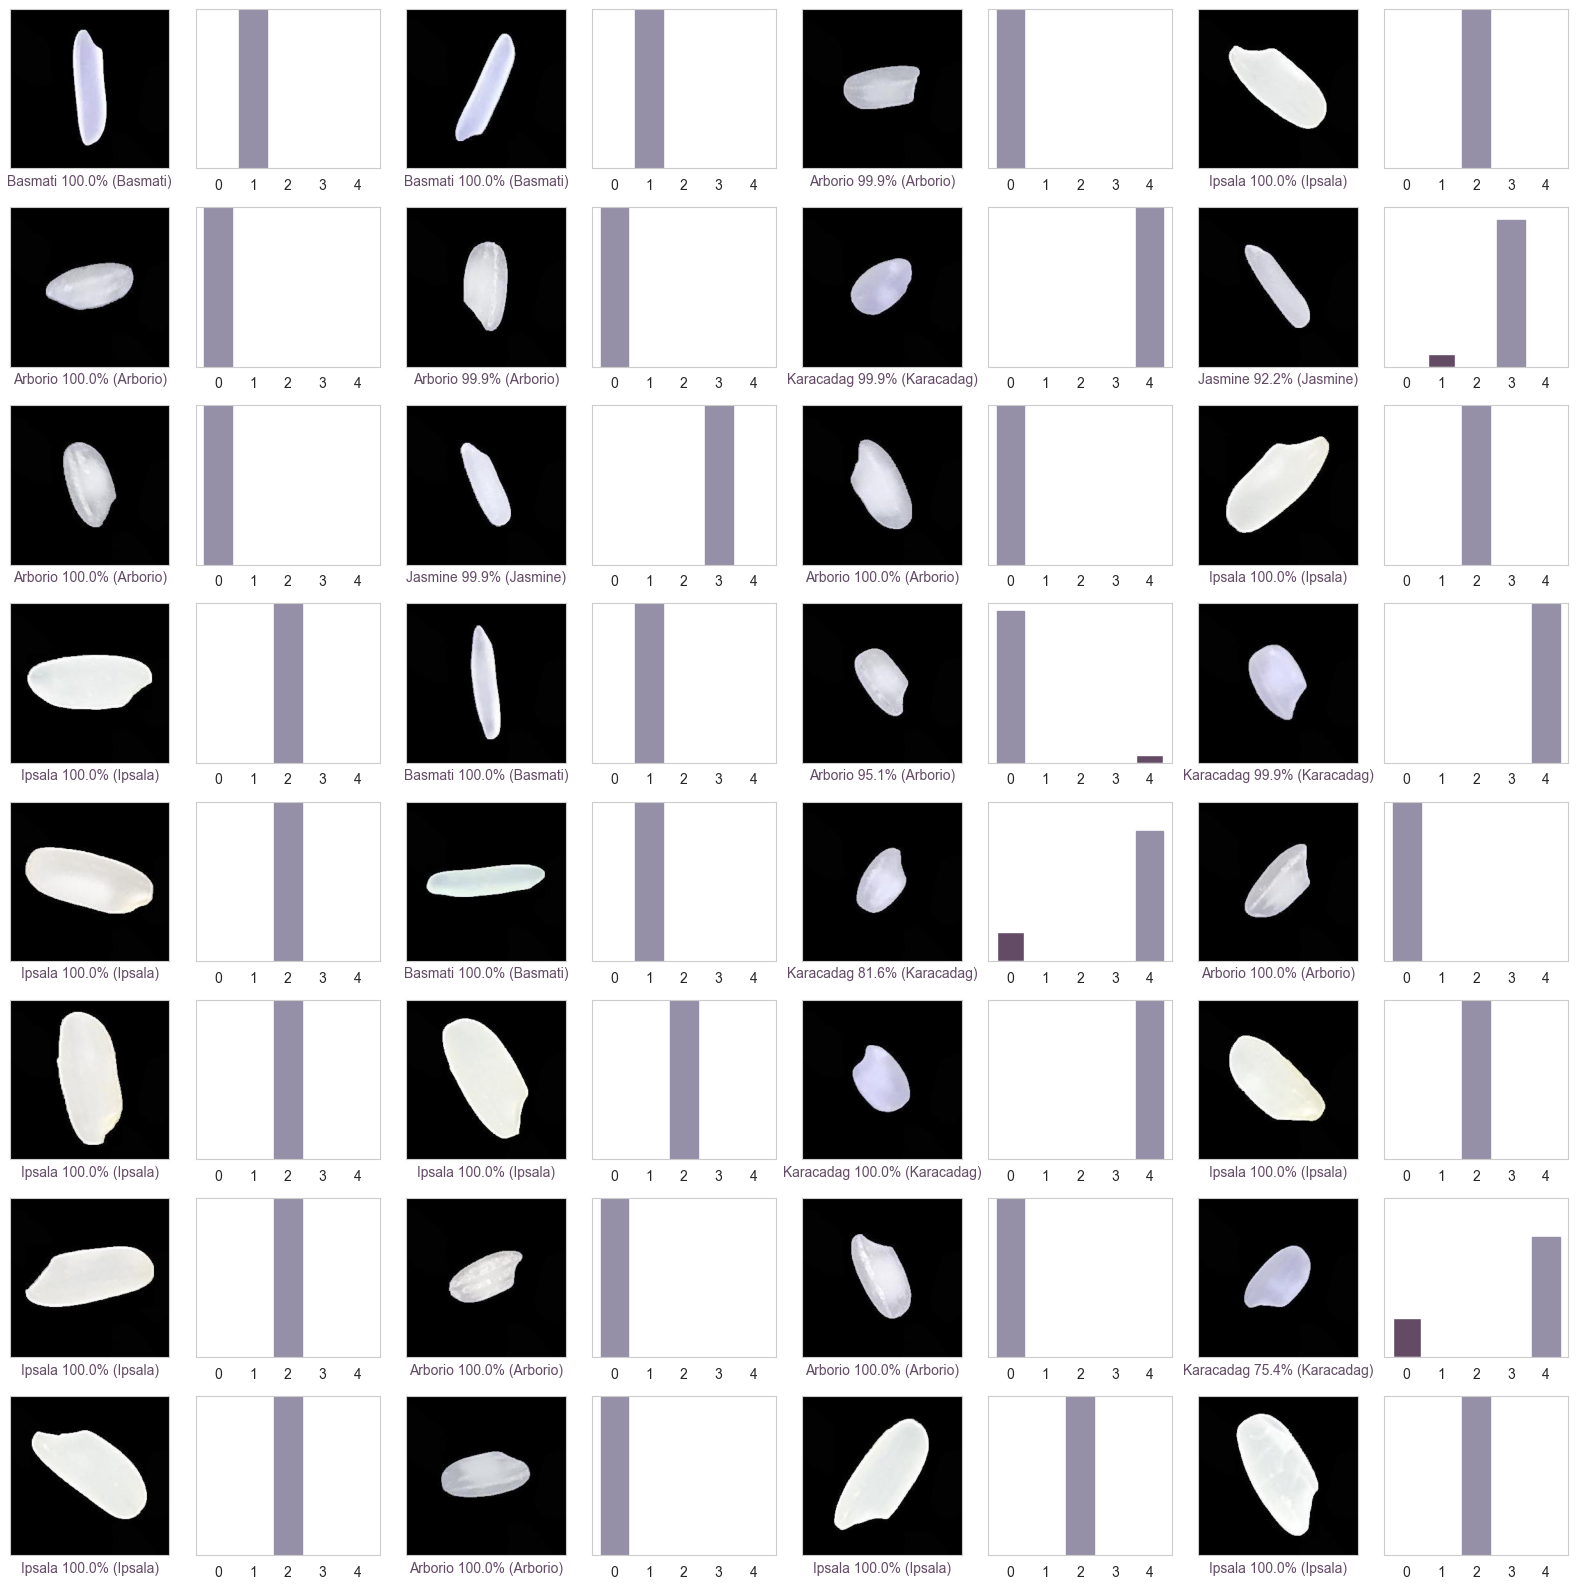

In [65]:
cpu_model = model.cpu()
for images_batch, true_labels in test_loader:
    break

def plot_image(output, true_label, img, class_names):
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    img_np = img.cpu().numpy().transpose((1, 2, 0))
    img_valid_range = np.clip(img_np, 0, 1)
    plt.imshow(img_valid_range)
    
    output = torch.softmax(output, dim=1)  # Apply softmax to get probabilities
    predicted_value, predicted_label = torch.max(output, dim=1)
    predicted_label = predicted_label.cpu().item()
    true_label = true_label.cpu().item()
    
    if predicted_label == true_label:
        color = '#634b66'
    else:
        color = '#e5ffde'
    
    plt.xlabel(f"{class_names[predicted_label]} {100 * predicted_value.item():.1f}% ({class_names[true_label]})", color=color)

def plot_value_array(output, true_label):
    output = torch.softmax(output, dim=1).squeeze()  # Apply softmax and remove singleton dimensions
    predicted_value, predicted_label = torch.max(output, dim=0)
    predicted_label = predicted_label.cpu().item()
    true_label = true_label.cpu().item()
    
    plt.grid(False)
    plt.xticks(range(len(output)))
    plt.yticks([])
    thisplot = plt.bar(range(len(output)), output.cpu().detach().numpy() * 100, color="#634b66")
    plt.ylim([0, 100])
    
    thisplot[predicted_label].set_color('#bbcbcb')
    thisplot[true_label].set_color('#9590a8')

def plot_model_result(outputs, test_labels, test_images, class_names, num_rows=8, num_cols=4):
    num_images = num_rows * num_cols
    plt.figure(figsize=(2 * 2 * num_cols, 2 * num_rows))
    for i in range(num_images):
        plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
        plot_image(outputs[i], test_labels[i], test_images[i], class_names)
        plt.subplot(num_rows, 2 * num_cols, 2 * i + 2)
        plot_value_array(outputs[i], test_labels[i])
    plt.tight_layout()
    plt.show()

outputs = []
for img in images_batch:
    img = img.unsqueeze(0).cpu()  
    with torch.no_grad():
        output = cpu_model(img)
    outputs.append(output.cpu())

# Plot model results
class_names = list(rice_variety_labels.values())  
plot_model_result(outputs, true_labels, images_batch, class_names)

In [67]:
model = model.to(Device)
y_true = []
y_pred = []
for images, labels in test_loader:
    images = images.to(Device)
    labels = labels.numpy()
    outputs = model(images)
    _, pred = torch.max(outputs.data, 1)
    pred = pred.detach().cpu().numpy()
    y_true = np.append(y_true, labels)
    y_pred = np.append(y_pred, pred)

In [68]:
print(colored("\nClassification Report:", 'cyan'))
class_names = list(rice_variety_labels.values())
report = classification_report(y_true, y_pred, target_names=class_names)

# Print the classification report with some formatting
print("="*60)
print(colored("Detailed Classification Report", 'magenta')) 
print("="*60)
print(report)
print("="*60)


Classification Report:
Detailed Classification Report
              precision    recall  f1-score   support

     Arborio       0.96      1.00      0.98      2250
     Basmati       0.99      0.99      0.99      2250
      Ipsala       1.00      1.00      1.00      2250
     Jasmine       0.99      0.99      0.99      2250
   Karacadag       1.00      0.96      0.98      2250

    accuracy                           0.99     11250
   macro avg       0.99      0.99      0.99     11250
weighted avg       0.99      0.99      0.99     11250

